In [18]:
# @title User Engagement on an Online Learning Platform
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import files
uploaded = files.upload()

# Load files
students_df = pd.read_csv('students.csv')
activity_df = pd.read_csv('course_activity.csv')
feedback_df = pd.read_csv('feedback.csv')


Saving feedback.csv to feedback.csv
Saving course_activity.csv to course_activity.csv
Saving students.csv to students.csv


In [4]:
# @title Data Cleaning & Preparation
# Convert to datetime
students_df['Enrolment_Date'] = pd.to_datetime(students_df['Enrolment_Date'], dayfirst=True)
activity_df['Date'] = pd.to_datetime(activity_df['Date'], dayfirst=True)

# Check for duplicates
print(students_df.duplicated().sum())
print(activity_df.duplicated().sum())
print(feedback_df.duplicated().sum())

print(students_df.isnull().sum())
print(activity_df.isnull().sum())
print(feedback_df.isnull().sum())

# Fill or drop missing values
activity_df = activity_df.dropna()


0
0
0
Student_ID        0
Name              0
Age               0
Gender            0
Location          0
Enrolment_Date    0
dtype: int64
Student_ID               0
Course_ID                0
Date                     0
Time_Spent_Minutes       0
Completion_Percentage    0
dtype: int64
Student_ID       0
Course_ID        0
Rating           0
Feedback_Text    0
dtype: int64


In [12]:
# @title Exploratory Data Analysis (EDA)
avg_completion_rate = activity_df['Completion_Percentage'].mean()
print(f"Overall average completion rate: {avg_completion_rate:.2f}%")


Overall average completion rate: 54.78%


In [13]:
engagement_by_course = activity_df.groupby('Course_ID')['Time_Spent_Minutes'].mean()
print("Highest engagement course:", engagement_by_course.idxmax(), engagement_by_course.max())
print("Lowest engagement course:", engagement_by_course.idxmin(), engagement_by_course.min())


Highest engagement course: DM101 102.42767295597484
Lowest engagement course: PY202 93.90243902439025



Engagement by Age Group:
Age_Group
<20       99.416107
20-25    101.828877
26-30     95.867403
31-35     94.718310
36-40           NaN
40+             NaN
Name: Time_Spent_Minutes, dtype: float64

Engagement by Location:
Location
Bangalore     98.000000
Chennai       90.946746
Delhi        103.302857
Kolkata      104.384615
Mumbai        95.435484
Name: Time_Spent_Minutes, dtype: float64


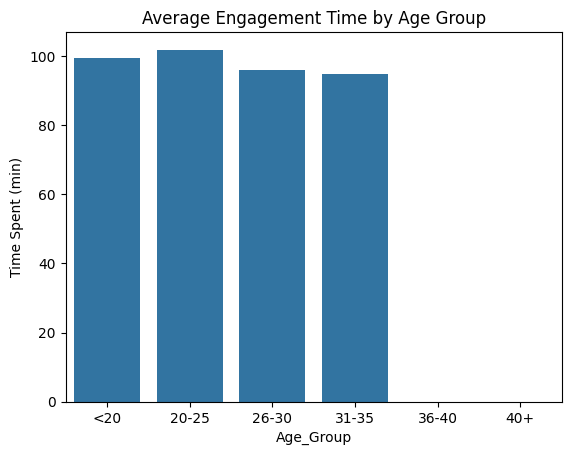

In [28]:
# Merge activity with student data
merged_activity = activity_df.merge(students_df, on='Student_ID')

# Age groups
bins = [0, 20, 25, 30, 35, 40, 100]
labels = ['<20', '20-25', '26-30', '31-35', '36-40', '40+']
merged_activity['Age_Group'] = pd.cut(merged_activity['Age'], bins=bins, labels=labels)

# Engagement by Age Group
eng_by_age = merged_activity.groupby('Age_Group', observed=False)['Time_Spent_Minutes'].mean() # Add observed=False here
print("\nEngagement by Age Group:")
print(eng_by_age)

# Engagement by Location
eng_by_loc = merged_activity.groupby('Location')['Time_Spent_Minutes'].mean()
print("\nEngagement by Location:")
print(eng_by_loc)

# Plot
sns.barplot(x=eng_by_age.index, y=eng_by_age.values)
plt.title("Average Engagement Time by Age Group")
plt.ylabel("Time Spent (min)")
plt.show()

In [15]:
avg_rating = feedback_df.groupby('Course_ID')['Rating'].mean()
print("\nAverage Feedback Rating per Course:")
print(avg_rating)



Average Feedback Rating per Course:
Course_ID
DM101    2.900000
PY202    3.277778
UX303    2.923077
WD404    2.789474
Name: Rating, dtype: float64


In [16]:
# Merge feedback and activity data
merged_feedback = feedback_df.merge(activity_df, on=['Student_ID', 'Course_ID'])
correlation = merged_feedback['Completion_Percentage'].corr(merged_feedback['Rating'])
print(f"\nCorrelation between Completion Rate and Feedback Rating: {correlation:.3f}")



Correlation between Completion Rate and Feedback Rating: -0.052


In [19]:
# Full merged data
full_df = feedback_df.merge(activity_df, on=['Student_ID', 'Course_ID']).merge(students_df, on='Student_ID')

# Aggregate by Student
student_stats = full_df.groupby('Student_ID').agg({
    'Time_Spent_Minutes': 'mean',
    'Rating': 'mean',
    'Age': 'first',
    'Gender': 'first',
    'Location': 'first'
}).reset_index()

# Standardize scores
scaler = StandardScaler()
student_stats[['Engagement_Score', 'Satisfaction_Score']] = scaler.fit_transform(
    student_stats[['Time_Spent_Minutes', 'Rating']]
)

# Combined score
student_stats['Combined_Score'] = student_stats['Engagement_Score'] + student_stats['Satisfaction_Score']

# Top 3 students
top_students = student_stats.sort_values(by='Combined_Score', ascending=False).head(3)
print("\nTop 3 Student Segments:")
print(top_students[['Student_ID', 'Age', 'Gender', 'Location', 'Time_Spent_Minutes', 'Rating', 'Combined_Score']])



Top 3 Student Segments:
   Student_ID  Age  Gender   Location  Time_Spent_Minutes  Rating  \
17       S036   25    Male    Chennai               175.0     5.0   
51       S083   25  Female     Mumbai               160.0     5.0   
47       S077   22    Male  Bangalore               148.0     5.0   

    Combined_Score  
17        3.101339  
51        2.721911  
47        2.418368  


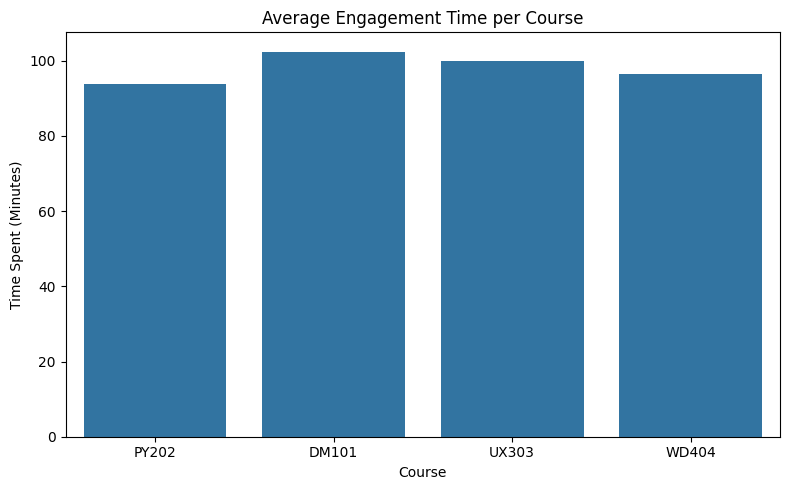

In [22]:
# @title Visualisations
# barplot
plt.figure(figsize=(8, 5))
sns.barplot(data=activity_df, x='Course_ID', y='Time_Spent_Minutes', estimator='mean', errorbar=None) # Use errorbar=None instead of ci=None
plt.title("Average Engagement Time per Course")
plt.ylabel("Time Spent (Minutes)")
plt.xlabel("Course")
plt.tight_layout()
plt.show()

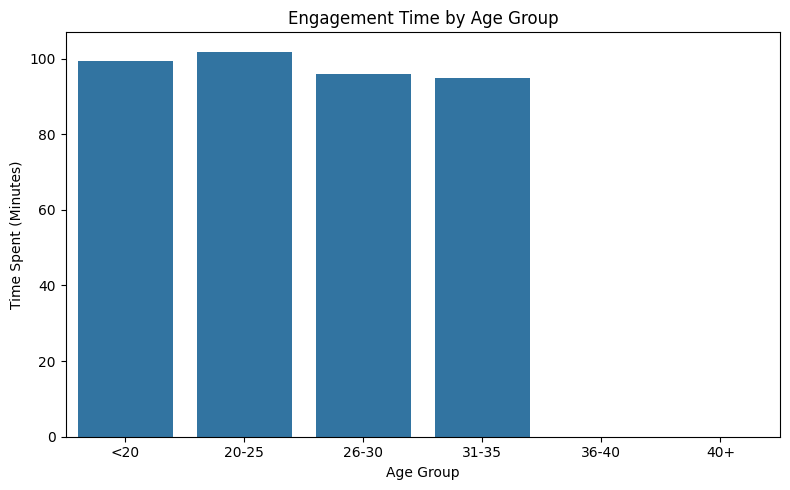

In [23]:
# barplot
# Merge with student data and create age groups
merged_activity = activity_df.merge(students_df, on='Student_ID')
bins = [0, 20, 25, 30, 35, 40, 100]
labels = ['<20', '20-25', '26-30', '31-35', '36-40', '40+']
merged_activity['Age_Group'] = pd.cut(merged_activity['Age'], bins=bins, labels=labels)

plt.figure(figsize=(8, 5))
sns.barplot(data=merged_activity, x='Age_Group', y='Time_Spent_Minutes', errorbar=None)  # Use errorbar=None instead of ci=None
plt.title("Engagement Time by Age Group")
plt.ylabel("Time Spent (Minutes)")
plt.xlabel("Age Group")
plt.tight_layout()
plt.show()

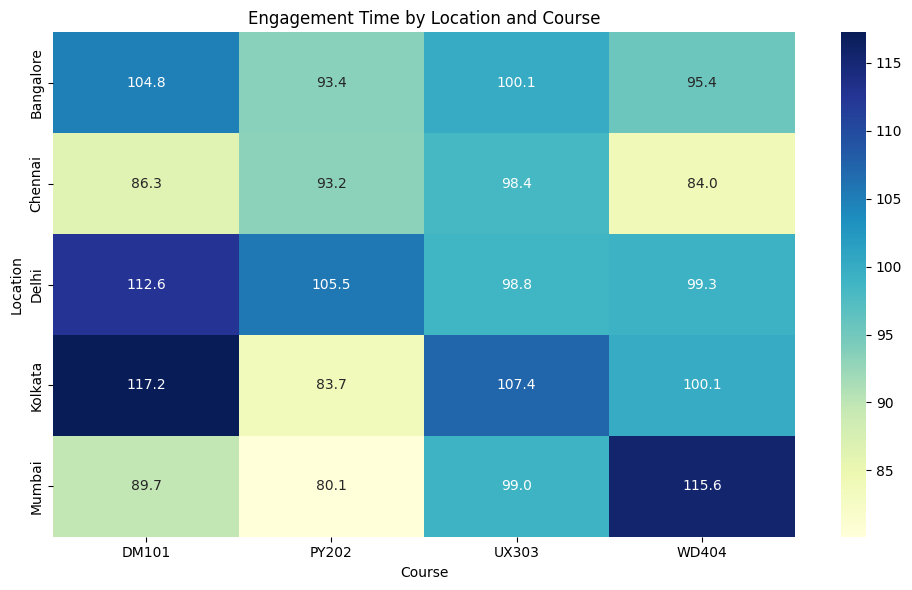

In [24]:
# Heatmap
heatmap_data = merged_activity.groupby(['Location', 'Course_ID'])['Time_Spent_Minutes'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Engagement Time by Location and Course")
plt.ylabel("Location")
plt.xlabel("Course")
plt.tight_layout()
plt.show()


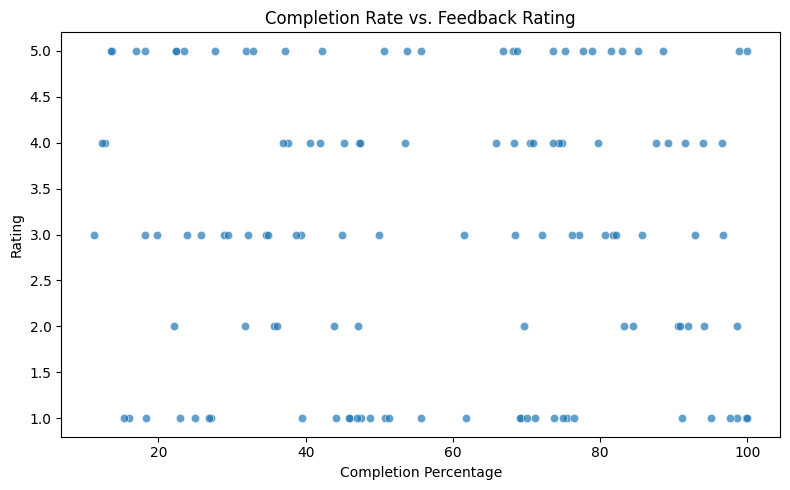

In [25]:
#Scatter Plot
merged_feedback = feedback_df.merge(activity_df, on=['Student_ID', 'Course_ID'])

plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_feedback, x='Completion_Percentage', y='Rating', alpha=0.7)
plt.title("Completion Rate vs. Feedback Rating")
plt.xlabel("Completion Percentage")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()


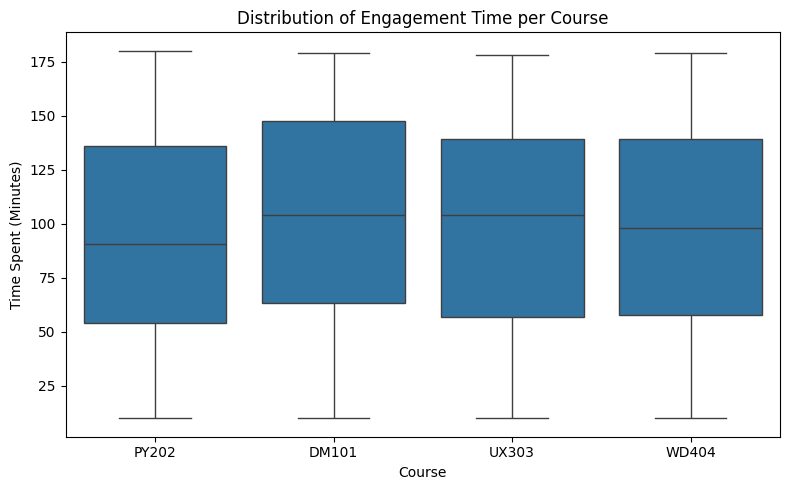

In [26]:
# Box Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=activity_df, x='Course_ID', y='Time_Spent_Minutes')
plt.title("Distribution of Engagement Time per Course")
plt.ylabel("Time Spent (Minutes)")
plt.xlabel("Course")
plt.tight_layout()
plt.show()


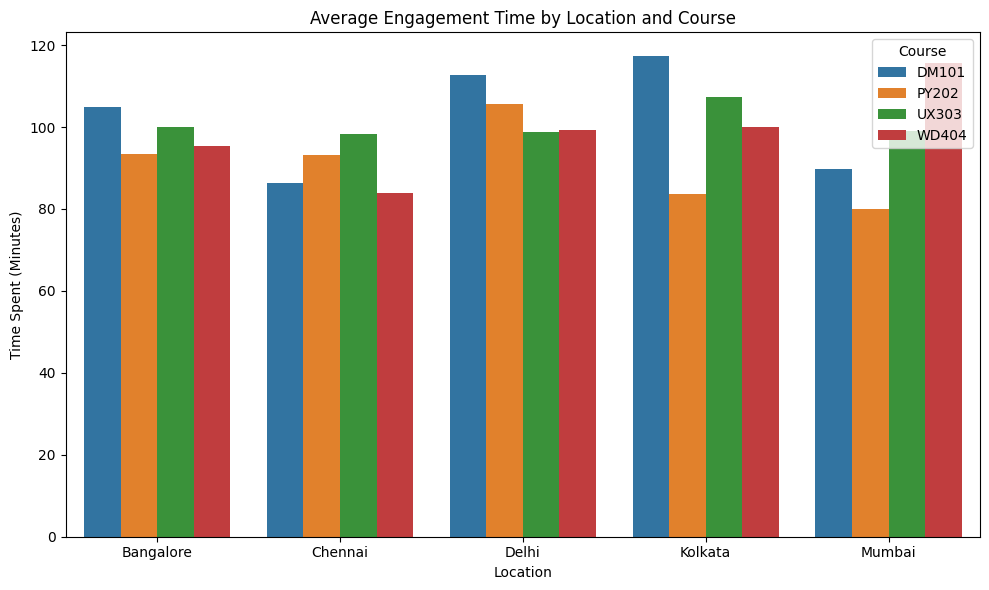

In [27]:
# Clustered Bar Chart
pivot_data = merged_activity.groupby(['Location', 'Course_ID'])['Time_Spent_Minutes'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_data, x='Location', y='Time_Spent_Minutes', hue='Course_ID')
plt.title("Average Engagement Time by Location and Course")
plt.ylabel("Time Spent (Minutes)")
plt.xlabel("Location")
plt.tight_layout()
plt.legend(title="Course")
plt.show()
